# PEAK FITTING (TUTORIAL)
V1: Jan 16, 2026

# 1. Lorentzian peak fitting for symmetric resonance peaks

The Lorentzian (or Cauchy) distribution is useful for characterizing resonance peaks. This section demonstrates fitting amplitude vs frequency data for the purposes of determining the resonance frequency and its uncertainty, based on a Lorentzian fitting function.

### Model Parameters

Although there are many The Lorentzian function is defined by three parameters:

1. **A**: Amplitude (peak height at resonance)
2. **x<sub>0</sub>**: Center position (resonance frequency)
3. **Γ (Gamma)**: Full Width at Half Maximum (FWHM) - the linewidth

The FWHM is the width of the peak measured at half of its maximum intensity, and it's directly related to the lifetime or relaxation time of the system.

### Mathematical Form

$$L(x) = \frac{A}{1 + \left(\frac{x - x_0}{\Gamma/2}\right)^2}$$

At $x = x_0 \pm \Gamma/2$, the function value is exactly $A/2$ by definition of the FWHM.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Lorentzian (Cauchy) peak profile with HWHM parameterization
def lorentzian(x, A, x0, gamma):
    return A / (1 + ((x - x0) / (gamma/2))**2)

# Calculate reduced chi-squared for goodness of fit
def chi_square(fit_function, fit_parameters, x, y, sigma):
    dof = len(x) - len(fit_parameters)
    return np.sum((y - fit_function(x, *fit_parameters))**2 / sigma**2) / dof

## Generate frequency peak data

Let's generate some data with the following characteristics

- **Frequency range**: 380-420 MHz (centered at 400 MHz)
- **Peak amplitude**: 10.0 (Arbitrary Units)
- **Γ (gamma, FWHM)**:  of 5.0 MHz
- **Measurement uncertainty**: 0.5 (Arbitrary Units, 5% of peak height)

In [2]:
### Generate data

# Parameters for data generation
A_true = 10       # Peak amplitude (arbitrary units)
f0_true = 400     # Center frequency (Hz)
gamma_true = 5    # FWHM, Γ (Hz)

# Generate frequency axis
x_data = np.linspace(380, 420, 50)  # 50 points from 380 to 420 Hz
x_model = np.linspace(x_data.min(), x_data.max(), 250) # smooth data for curves

# Define constant y-uncertainty
y_sigma = np.full_like(x_data, 0.5)  # Constant measurement uncertainty

# Generate perfect Lorentzian profile
y_perfect = lorentzian(x_data, A_true, f0_true, gamma_true)

# Add Gaussian noise to simulate experimental data
np.random.seed(42)  # For reproducibility
y_data = y_perfect + np.random.normal(0, y_sigma)

### Visualize the Data

Before fitting, let's have a look at the data

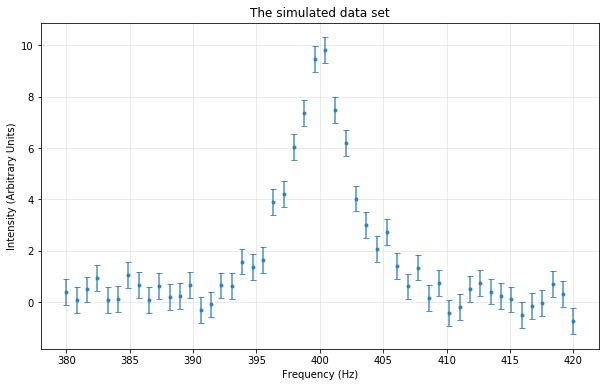

In [3]:
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='.', linestyle='', 
             capsize=3, alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity (Arbitrary Units)")
plt.title("The simulated data set")
plt.grid(True, alpha=0.3)
plt.show()

## Estimate Initial Parameter Guesses

Good initial guesses help the fitting algorithm converge faster and avoid local minima. We can estimate:

1. **Amplitude (A)**: Maximum y-value in the data

In [4]:
A_guess = np.max(y_data)
print(A_guess)

9.795826406416774


2. **The peak frequency (f<sub>0</sub>)**

In [5]:
f0_guess = x_data[np.argmax(y_data)]
print(f0_guess)

400.40816326530614


3. **FWHM (Γ)**: Estimate by finding the full width at half-maximum. We find points where $y \geq A/2$, calculate FWHM by the distance between the leftmost and rightmost of these points points.

In [6]:
half_max = A_guess / 2
indices_half = np.where(y_data >= half_max)[0]
if len(indices_half) >= 2:
    fwhm_estimate = x_data[indices_half[-1]] - x_data[indices_half[0]]  # Full width
    gamma_guess = fwhm_estimate
else:
    gamma_guess = 5  # Fallback default (FWHM)
print(gamma_guess)

4.081632653061206


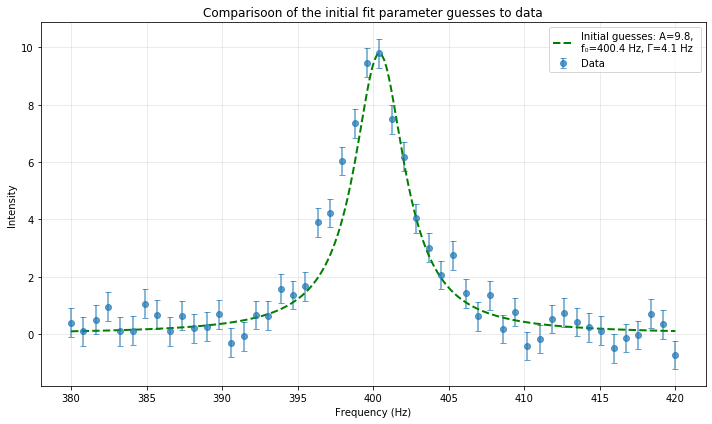

In [7]:
# Visualize initial guesses vs data
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='o', linestyle='', 
             capsize=3, label="Data", alpha=0.7)
plt.plot(x_model, lorentzian(x_model, A_guess, f0_guess, gamma_guess), 'g--', linewidth=2, 
         label=f"Initial guesses: A={A_guess:.1f}, \nf₀={f0_guess:.1f} Hz, Γ={gamma_guess:.1f} Hz")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity")
plt.title("Comparisoon of the initial fit parameter guesses to data")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Perform and visualize Lorentzian fit

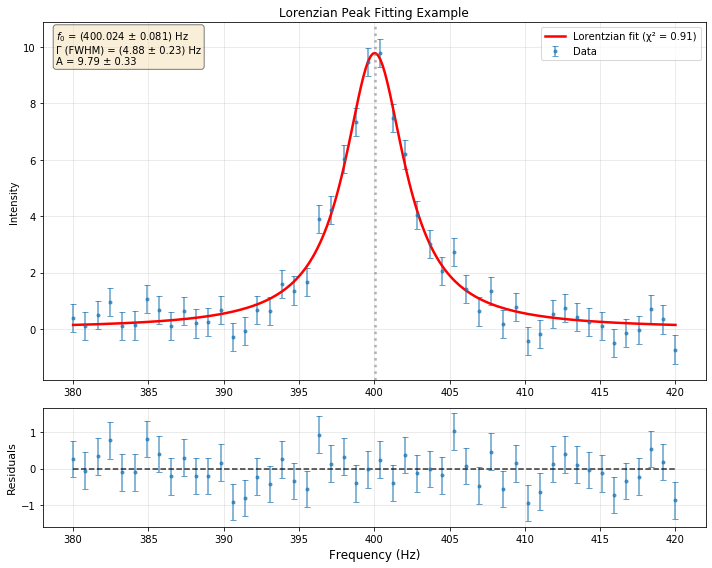

In [8]:
# Perform weighted least-squares fit

p0_guesses = [A_guess, f0_guess, gamma_guess]

fit_params, fit_cov = curve_fit(
    lorentzian, x_data, y_data,
    p0 = p0_guesses,
    sigma = y_sigma,       # Include y uncertainties
    absolute_sigma = True  # Scale fit parameter uncertainties correctly
)

# Extract fitted parameters and uncertainties
A_fit, f0_fit, gamma_fit = fit_params
A_unc, f0_unc, gamma_unc = np.sqrt(np.diag(fit_cov))

# Calculate reduced chi-squared
chi2 = chi_square(lorentzian, fit_params, x_data, y_data, y_sigma)

# Make plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8), 
                       gridspec_kw={'height_ratios': [3, 1]})

# Top panel: Data + fit + HWHM visualization
y_fit = lorentzian(x_model, *fit_params)

ax[0].errorbar(x_data, y_data, yerr=y_sigma, marker='.', linestyle='', 
               capsize=3, label="Data", alpha=0.7)
ax[0].plot(x_model, y_fit, 'r-', linewidth=2.5, 
           label=f"Lorentzian fit (χ² = {chi2:.2f})")

# Mark center with vertical line
ax[0].axvline(f0_fit, color='gray', linestyle=':', linewidth=2.5, alpha=0.6)

# Add text box with fit parameters
textstr = (
    f'$f_0$ = ({f0_fit:.3f} ± {f0_unc:.3f}) Hz\n'
    + f'Γ (FWHM) = ({gamma_fit:.2f} ± {gamma_unc:.2f}) Hz\n'
    + f'A = {A_fit:.2f} ± {A_unc:.2f}'
)
ax[0].text(0.02, 0.98, textstr, transform=ax[0].transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax[0].set_ylabel("Intensity") 
ax[0].set_title(f"Lorenzian Peak Fitting Example")
ax[0].legend(loc='upper right')
ax[0].grid(True, alpha=0.3)

# Bottom panel: Residuals
residual = y_data - lorentzian(x_data, *fit_params)
ax[1].errorbar(x_data, residual, yerr=y_sigma, marker='.', linestyle='', capsize=3, alpha=0.7)
ax[1].hlines(0, np.min(x_data), np.max(x_data), lw=1.5, alpha=0.8, color="k", linestyle="--")
ax[1].set_xlabel("Frequency (Hz)", fontsize=12)
ax[1].set_ylabel("Residuals", fontsize=11)
ax[1].grid(True, alpha=0.3)
ax[1].legend

plt.tight_layout()
plt.show()

# 2. Fano peak fitting for asymmetric resonance peaks

You may find that the resonance data you collect in Phys 229 has a clear peak, but is much too asymmetric to be described by our Lorenzian function. An example of a very asymmetric data set is shown below.

This happens due to a phenomenon known as [Fano resonance](https://en.wikipedia.org/wiki/Fano_resonance), which in our pipe resonance experiment manifests when the standing wave in the pipe interferes with the sound wave coming directly from the speaker. The consequence is that the frequencies fall off asymmetrically on either side of the resonance peak due due to a frequency-dependent phase difference between the direct sound wave and the standing wave. 

You may wish to try moving the microphone or the speaker slightly to see how you changing the path length of the direct sound wave (i.e., the distance between the microphone and speaker) impacts how asymmetric your amplitude-frequency data are.

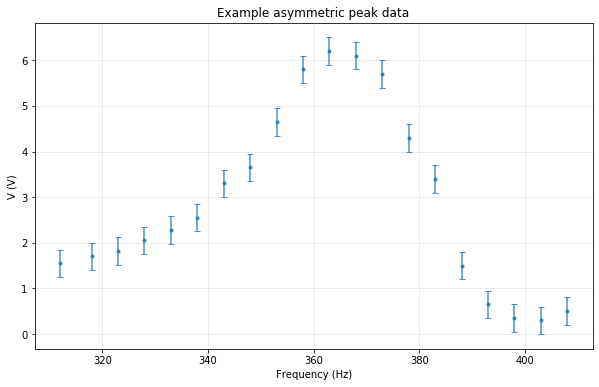

In [9]:
# Load and plot our asymmetric data

# Frequency data
x_data = np.array([312, 318, 323, 328, 333, 338, 343, 348, 353, 358, 
                 363, 368, 373, 378, 383, 388, 393, 398, 403, 408])

# Voltage data
y_data = np.array([1.55, 1.70, 1.82, 2.05, 2.28, 2.55, 3.30, 3.65, 4.65, 5.80,
                      6.20, 6.10, 5.70, 4.30, 3.40, 1.50, 0.65, 0.35, 0.30, 0.50])

y_sigma = np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 
                      0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

x_model = np.linspace(np.min(x_data), np.max(x_data), 250) # smooth data for curves

plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='.', linestyle='', 
             capsize=3, alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("V (V)")
plt.title("Example asymmetric peak data")
plt.grid(True, alpha=0.3)
plt.show()

Fano resonance is described by the following function, where the function approaches a Lorenzian as the magnitude of the asymmetry parameter `q` approaches infinity.

In [10]:
# Fano function
def fano(f, f0, gamma, q, scaling, y_offset):
    """
    f0       : resonant frequency
    gamma    : full width at half maximum (FWHM)
    q        : asymmetry parameter (|q|→∞ gives Lorentzian)
    scaling  : A scaling factor related to peak height above background (A) by
               A = scaling * (q^2 + 1) + y_offset
    y_offset : offset to account for background or similar
    """
    epsilon = (f - f0) / (gamma / 2)
    return scaling * (q + epsilon)**2 / (1 + epsilon**2) + y_offset

This function has 5 (!!!) fit parameters, so let's try to make reasonable initial estimates of each of them. 

In [11]:
# Initial guesses for fit parameters
# These may need adjustment for your data
p0_guesses = [
    365,    # f0: ~ from visual inspection 
    35,     # gamma: ~ 350-385 Haz
    -2,     # q: negative for sharp drop on high-freq side (opposite of q=2 picture on wikipedia)
    1.2,      # scaling: By inpsection the amplitude A is ~ 6. Thus ths scaling factor is 
            # 6 = scaling * ((-2)^2 + 1) + 0  =>  scaling = 6/5 = 1.2         
    0       # y_offset: assume it is small
]

Let's visualize the function vs the data using these initial estimates

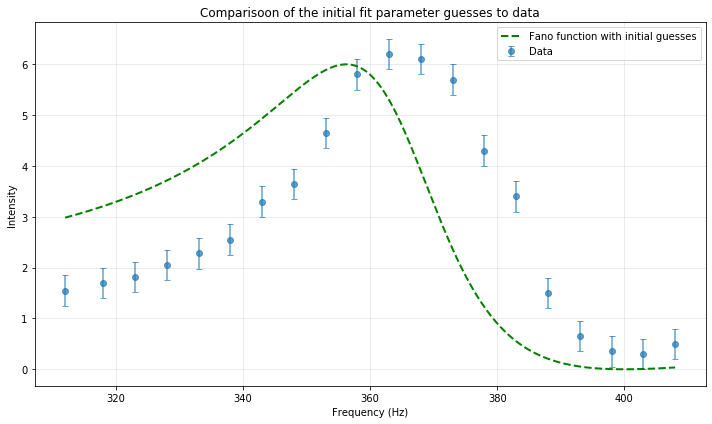

In [12]:
# Visualize initial guesses vs data
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='o', linestyle='', 
             capsize=3, label="Data", alpha=0.7)
plt.plot(x_model, fano(x_model, *p0_guesses), 'g--', linewidth=2, 
         label=f"Fano function with initial guesses")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity")
plt.title("Comparisoon of the initial fit parameter guesses to data")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion:** It looks like some of our estimates were reasonable, such as `q` and `scaling`. However, we can see that when we plot the Fano function with a specified peak frequency (in our example $f_0 = 365 \text{Hz}$), the function peak is shifted relative to the where the peak in the data appears. Inspection of the Fano equation reveals we should expect the following relationship between $f_0$ that we use in the fano function and where we would observe the peak when we graph this function, $f_\text{data peak}$:

$$f_0 = f_\text{data peak} - \dfrac{\Gamma}{2q}$$

So what this means is we need to make our estimate for $f_0$ higher by an amount of

$$\dfrac{\Gamma}{2q} = \dfrac{35Hz}{2(-2)} \approx 9 Hz $$

So let's add these 9 Hz to our $f_0$ estimate.

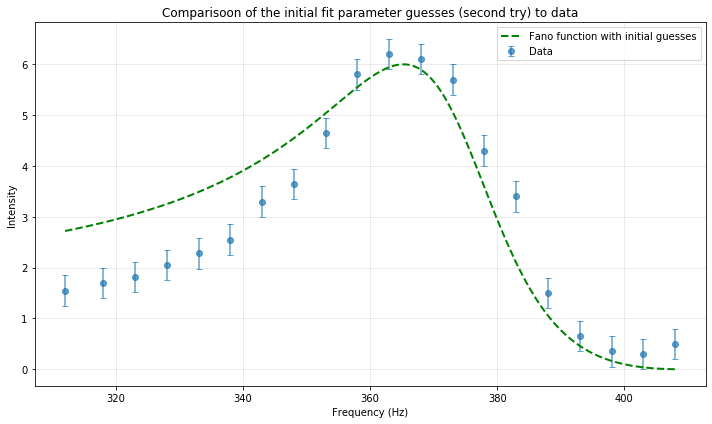

In [13]:
# Initial guesses for fit parameters
# These may need adjustment for your data
p0_guesses = [
    365 + 9, # f0: Shift the peak to the right by 9 Hz as compared to f(data peak)
    35, 
    -2,  
    1.2,      # A: Let's reduce this by a factor 5
    0   
]

# Visualize initial guesses vs data
plt.figure(figsize=(10, 6))
plt.errorbar(x_data, y_data, yerr=y_sigma, marker='o', linestyle='', 
             capsize=3, label="Data", alpha=0.7)
plt.plot(x_model, fano(x_model, *p0_guesses), 'g--', linewidth=2, 
         label=f"Fano function with initial guesses")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity")
plt.title("Comparisoon of the initial fit parameter guesses (second try) to data")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion:** This second set of initial fit parameter estimates seems close enough to the data to give us confidence to proceed with performing our fit.

Let's perform the fit.

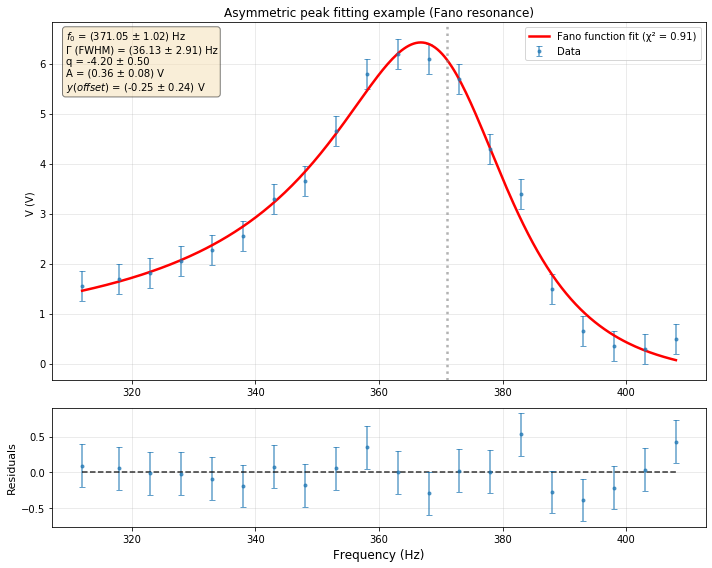

In [14]:
# The fano fit of the asymmetric data
fit_params, fit_cov = curve_fit(fano, x_data, y_data, p0=p0_guesses, sigma=y_sigma, absolute_sigma=True)

# Extract fitted parameters and uncertainties
f0_fit, gamma_fit, q_fit, A_fit, offset_fit = fit_params
f0_unc, gamma_unc, q_unc, A_unc, offset_unc = np.sqrt(np.diag(fit_cov))

# Make plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8), 
                       gridspec_kw={'height_ratios': [3, 1]})

# Top panel
y_fit = fano(x_model, *fit_params)

ax[0].errorbar(x_data, y_data, yerr=y_sigma, marker='.', linestyle='', 
               capsize=3, label="Data", alpha=0.7)
ax[0].plot(x_model, y_fit, 'r-', linewidth=2.5, 
           label=f"Fano function fit (χ² = {chi2:.2f})")

# Mark f_0 with a vertical line
ax[0].axvline(f0_fit, color='gray', linestyle=':', linewidth=2.5, alpha=0.6)

# Add text box with fit parameters
textstr = (
    f'$f_0$ = ({f0_fit:.2f} ± {f0_unc:.2f}) Hz\n'
    + f'Γ (FWHM) = ({gamma_fit:.2f} ± {gamma_unc:.2f}) Hz\n'
    + f'q = {q_fit:.2f} ± {q_unc:.2f}\n'
    + f'A = ({A_fit:.2f} ± {A_unc:.2f}) V\n'
    + f'$y(offset)$ = ({offset_fit:.2f} ± {offset_unc:.2f}) V'
)
ax[0].text(0.02, 0.98, textstr, transform=ax[0].transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax[0].set_ylabel("V (V) ") 
ax[0].set_title(f"Asymmetric peak fitting example (Fano resonance)")
ax[0].legend(loc='upper right')
ax[0].grid(True, alpha=0.3)

# Bottom panel: Residuals
residual = y_data - fano(x_data, *fit_params)
ax[1].errorbar(x_data, residual, yerr=y_sigma, marker='.', linestyle='', capsize=3, alpha=0.7)
ax[1].hlines(0, np.min(x_data), np.max(x_data), lw=1.5, alpha=0.8, color="k", linestyle="--")
ax[1].set_xlabel("Frequency (Hz)", fontsize=12)
ax[1].set_ylabel("Residuals", fontsize=11)
ax[1].grid(True, alpha=0.3)
ax[1].legend

plt.tight_layout()
plt.show()

**Discussion:** We see that the overall fit looks reasonably good. We see a possible pattern/trend below 340 Hz, as well as above 390 Hz, but for our purposes this chi-squared near 1 and reasonably well-behaved residuals gives us confidence that the Fano function describes our data well.

**More discussion:** Our system has a natural resonance frequency of $f_0$, which is what we would measure as our peak frequency if the Fano asymmetry weren't present. This asymmetry arises because the direct path from speaker to microphone creates interference with the standing wave. The result is that the measured peak shifts by an amount $\frac{\Gamma}{2q}$ relative to the system's natural resonance frequency of $f_0$.

**Take-home message:** Although $f_0$ doesn't line up with the apparent peak in the data, it represents the natural harmonic resonance frequency, which is the quantity you want for your subsequent analyses.